# Переводчик на seq2seq Attention Transformer

In [1]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

Using TensorFlow backend.


In [30]:
batch_size = 1024
epochs = 100
latent_dim = 256
num_samples = 30000
data_path = 'data/rus-eng/rus.txt'

In [31]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read()[:1000]
    print(lines)

Go.	Марш!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)
Go.	Иди.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)
Go.	Идите.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)
Hi.	Здравствуйте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)
Hi.	Привет!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)
Hi.	Хай.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #467233 (timsa)
Hi.	Здрасте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3803577 (marafon)
Hi.	Здоро́во!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3854188 (marafon)
Run!	Беги!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1569978 (Biga)
Run!	Бегите!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2770234 (marafon)
Run.	Беги!	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #1569978 (Bi

### Препроцессинг, очистка текста в последовательности

In [32]:
# Собираем из текстов токены и делаем one-hot вектора на каждый токен

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [33]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [34]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [35]:
# Задаем размеры последовательности

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

### Обучение базового seq2seq

Тестовая генерация. В данной модели в LSTM-ячейку подается посимвольная последовательность

In [8]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# Подача выхода энкодера в декодер
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Подача выхода декодера в модель
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence


for seq_index in range(0, 500, 10):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Train on 24000 samples, validate on 6000 samples
Epoch 1/100
24000/24000 [==============================] - 8s 329us/step - loss: 2.1781 - accuracy: 0.7215 - val_loss: 1.4754 - val_accuracy: 0.7248
Epoch 2/100
24000/24000 [==============================] - 7s 291us/step - loss: 1.2270 - accuracy: 0.7554 - val_loss: 1.2855 - val_accuracy: 0.7251
Epoch 3/100
24000/24000 [==============================] - 7s 291us/step - loss: 1.0927 - accuracy: 0.7541 - val_loss: 1.2066 - val_accuracy: 0.7242
Epoch 4/100
24000/24000 [==============================] - 7s 293us/step - loss: 1.0233 - accuracy: 0.7507 - val_loss: 1.1139 - val_accuracy: 0.7245
Epoch 5/100
24000/24000 [==============================] - 7s 293us/step - loss: 0.9516 - accuracy: 0.7559 - val_loss: 1.0449 - val_accuracy: 0.7278
Epoch 6/100
24000/24000 [==============================] - 7s 293us/step - loss: 0.9028 - accuracy: 0.7579 - val_loss: 1.0027 - val_accuracy: 0.7260
Epoch 7/100
24000/24000 [==============================] 

24000/24000 [==============================] - 8s 313us/step - loss: 0.4231 - accuracy: 0.8776 - val_loss: 0.5188 - val_accuracy: 0.8502
Epoch 56/100
24000/24000 [==============================] - 7s 294us/step - loss: 0.4205 - accuracy: 0.8783 - val_loss: 0.5139 - val_accuracy: 0.8514
Epoch 57/100
24000/24000 [==============================] - 7s 309us/step - loss: 0.4174 - accuracy: 0.8792 - val_loss: 0.5124 - val_accuracy: 0.8523
Epoch 58/100
24000/24000 [==============================] - 8s 317us/step - loss: 0.4146 - accuracy: 0.8800 - val_loss: 0.5091 - val_accuracy: 0.8536
Epoch 59/100
24000/24000 [==============================] - 8s 318us/step - loss: 0.4118 - accuracy: 0.8808 - val_loss: 0.5068 - val_accuracy: 0.8546
Epoch 60/100
24000/24000 [==============================] - 8s 317us/step - loss: 0.4097 - accuracy: 0.8813 - val_loss: 0.5068 - val_accuracy: 0.8537
Epoch 61/100
24000/24000 [==============================] - 8s 318us/step - loss: 0.4077 - accuracy: 0.8818 - val

-
Input sentence: Help me!
Decoded sentence: Помоги мне!

-
Input sentence: Hit Tom.
Decoded sentence: Подмишь Том.

-
Input sentence: I agree.
Decoded sentence: Я полодный.

-
Input sentence: I slept.
Decoded sentence: Я потал.

-
Input sentence: I'll go.
Decoded sentence: Я пойду.

-
Input sentence: I'm ill.
Decoded sentence: Я володан.

-
Input sentence: I'm shy.
Decoded sentence: Я том.

-
Input sentence: I'm wet.
Decoded sentence: Я потредная.

-
Input sentence: Keep it.
Decoded sentence: Оставьте его.

-
Input sentence: Lock it.
Decoded sentence: Заприте его.

-
Input sentence: Perfect!
Decoded sentence: Придеми!

-
Input sentence: Show me.
Decoded sentence: Покажите мне.

-
Input sentence: Stop it.
Decoded sentence: Прекратите его.

-
Input sentence: Tom won.
Decoded sentence: Том был пол.

-
Input sentence: Wake up.
Decoded sentence: Просысь.

-
Input sentence: Who won?
Decoded sentence: Кто это слашил?

-
Input sentence: Am I fat?
Decoded sentence: Я тобе полодно?

-
Input sen

## Поднимемся на уровень слов, чтобы можно было что-то более адекватное посчитать за адекватное время

## Добавление Attention уровня

In [122]:
import re
import tensorflow as tf
data_path = 'data/rus-eng/rus.txt'
num_samples = 20000


input_texts = []
target_texts = []

def preprocess_sentence(w):
    
    """Предобработка пунктуации последовательности"""
        
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Zа-яА-Я]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(preprocess_sentence(input_text))
    target_texts.append(preprocess_sentence(target_text))

In [123]:
input_texts[:2], target_texts[:2]

(['<start> Go <end>', '<start> Go <end>'],
 ['<start> Марш <end>', '<start> Иди <end>'])

In [124]:
lines[:5]

['Go.\tМарш!\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)',
 'Go.\tИди.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)',
 'Go.\tИдите.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)',
 'Hi.\tЗдравствуйте.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)',
 'Hi.\tПривет!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)']

In [125]:
inp, truth, _ = lines[0].split("\t")
print("input:", inp)
print("groundtruth:", truth)
print("-", _)

input: Go.
groundtruth: Марш!
- CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)


In [126]:
preprocess_sentence(inp)

'<start> Go <end>'

In [127]:
preprocess_sentence(truth)

'<start> Марш <end>'

In [128]:
def tokenize(lang:list):
    
    """
    Токенизация текста
    
    Parameters
    ----------
    
    lang:list
        Список последовательностей - выражений для одного языка
        Пример input ['<start> Go . <end>', '<start> Go . <end>', ...]
        
    Returns
    -------
    
    tensor: numpy.ndarray
        Тензор токенизированной последовательности
        
    lang_tokenizer: keras_preprocessing.text.Tokenizer
            Токенайзер из модуля tf.keras
    
    """
    
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

In [129]:
input_tensor, inp_lang_tokenizer = tokenize(input_texts)
target_tensor, targ_lang_tokenizer = tokenize(target_texts)

In [130]:
from sklearn.model_selection import train_test_split

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [131]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = batch_size
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [132]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.lstm(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

    
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [133]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [134]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [135]:
for epoch in range(epochs):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

Epoch 1 Loss 2.6567
Epoch 2 Loss 2.0842
Epoch 3 Loss 1.9482
Epoch 4 Loss 1.8286
Epoch 5 Loss 1.7521
Epoch 6 Loss 1.7036
Epoch 7 Loss 1.6659
Epoch 8 Loss 1.6301
Epoch 9 Loss 1.5914
Epoch 10 Loss 1.5727
Epoch 11 Loss 1.5124
Epoch 12 Loss 1.4423
Epoch 13 Loss 1.3724
Epoch 14 Loss 1.3111
Epoch 15 Loss 1.2599
Epoch 16 Loss 1.2085
Epoch 17 Loss 1.1609
Epoch 18 Loss 1.1204
Epoch 19 Loss 1.0795
Epoch 20 Loss 1.0513
Epoch 21 Loss 1.0098
Epoch 22 Loss 0.9724
Epoch 23 Loss 0.9350
Epoch 24 Loss 0.9076
Epoch 25 Loss 0.8749
Epoch 26 Loss 0.8370
Epoch 27 Loss 0.8033
Epoch 28 Loss 0.7704
Epoch 29 Loss 0.7424
Epoch 30 Loss 0.7125
Epoch 31 Loss 0.6824
Epoch 32 Loss 0.6493
Epoch 33 Loss 0.6157
Epoch 34 Loss 0.5854
Epoch 35 Loss 0.5566
Epoch 36 Loss 0.5293
Epoch 37 Loss 0.5037
Epoch 38 Loss 0.4757
Epoch 39 Loss 0.4509
Epoch 40 Loss 0.4258
Epoch 41 Loss 0.4088
Epoch 42 Loss 0.3835
Epoch 43 Loss 0.3619
Epoch 44 Loss 0.3439
Epoch 45 Loss 0.3260
Epoch 46 Loss 0.3072
Epoch 47 Loss 0.2914
Epoch 48 Loss 0.2771
E

In [137]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

from matplotlib import pyplot as plt
from matplotlib import ticker

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Populating the interactive namespace from numpy and matplotlib


C:\Users\Nickel\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Input: <start> good morning <end>
Predicted translation: доброе утро <end> 


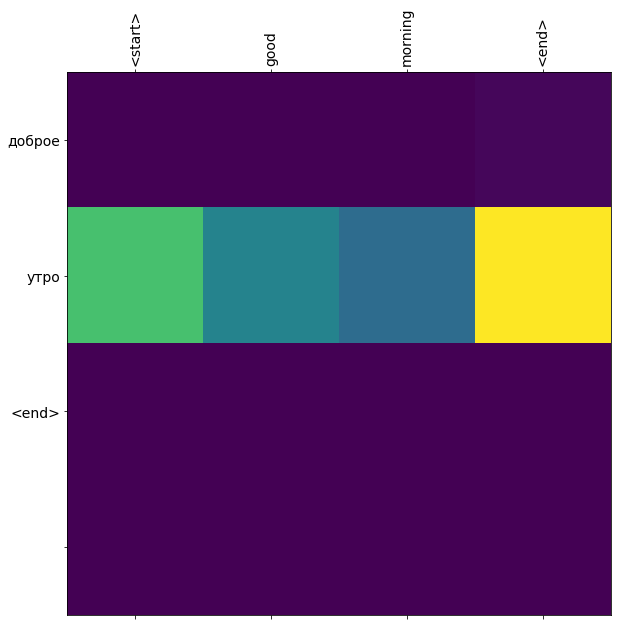

In [138]:
%pylab inline

translate(u'good morning')

Populating the interactive namespace from numpy and matplotlib
Input: <start> good for you <end>
Predicted translation: рад за тебя <end> 


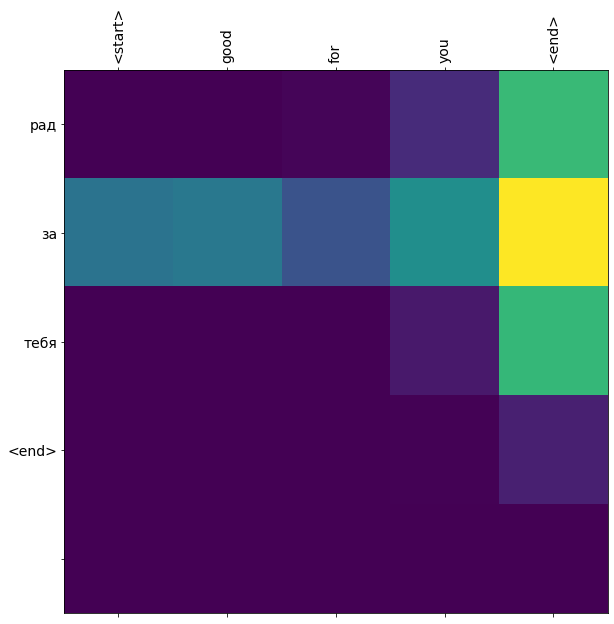

In [153]:
%pylab inline

translate(u'good for you')

# Transformer

Идея в том, что каждое слово параллельно проходит через слои, изображенные на картинке. Некоторые из них — это стандартные fully-connected layers, некоторые — shortcut connections как в ResNet (там, где на картинке Add).

Multi-head attention - это специальный новый слой, который дает возможность каждому входному вектору взаимодействовать с другими словами через attention mechanism, вместо передачи hidden state как в RNN или соседних слов как в CNN.

Работа энкодера:

Делаются эмбеддинги для всех слов предложения (вектора одинаковой размерности). Для примера пусть это будет предложение I am stupid. В эмбеддинг добавляется еще позиция слова в предложении.

Берется вектор первого слова и вектор второго слова (I, am), подаются на однослойную сеть с одним выходом, которая выдает степень их похожести (скалярная величина). Эта скалярная величина умножается на вектор второго слова, получая его некоторую "ослабленную" на величину похожести копию.

Вместо второго слова подается третье слово и делается тоже самое что в п.2. с той же самой сетью с теми же весами (для векторов I, stupid).

Делая тоже самое для всех оставшихся слов предложения получаются их "ослабленные" (взвешенные) копии, которые выражают степень их похожести на первое слово. Далее эти все взвешенные вектора складываются друг с другом, получая один результирующий вектор размерности одного эмбединга: output=am * weight(I, am) + stupid * weight(I, stupid)

Это механизм "обычного" attention. Так как оценка похожести слов всего одним способом (по одному критерию) считается недостаточной, тоже самое (п.2-4) повторяется несколько раз с другими весами. Типа одна один attention может определять похожесть слов по смысловой нагрузке, другой по грамматической, остальные еще как-то и т.п.

На выходе п.5. получается несколько векторов, каждый из которых является взвешенной суммой всех остальных слов предложения относительно их похожести на первое слово (I). Конкантенируем этот вректор в один.

Дальше ставится еще один слой линейного преобразования, уменьшающий размерность результата п.6. до размерности вектора одного эмбединга. Получается некое представление первого слова предложения, составленное из взвешенных векторов всех остальных слов предложения.

Такой же процесс производится для всех других слов в предложении.

Так как размерность выхода та же, то можно проделать все тоже самое еще раз (п.2-8), но вместо оригинальных эмбеддингов слов взять то, что получается после прохода через этот Multi-head attention, а нейросети аттеншенов внутри взять с другими весами (веса между слоями не общие). И таких слоев можно сделать много (у гугла 6). Однако между первым и вторым слоем добавляется еще полносвязный слой и residual соединения, чтобы добавить сети выразительности.

In [154]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights

In [155]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        
        """Разделение последней размерности на (num_heads, depth).
        Транспонирование реультата к размерности (batch_size, num_heads, seq_len, depth)
        """
        
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [156]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2
    
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [157]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [158]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [159]:
# 

num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(inp_lang_tokenizer.index_word) + 2
target_vocab_size = len(targ_lang_tokenizer.index_word) + 2
dropout_rate = 0.1

In [160]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [161]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [162]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [163]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [164]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
  
    dec_padding_mask = create_padding_mask(inp)
  
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [165]:

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [166]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

for epoch in range(100):
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset.take(steps_per_epoch)):
        train_step(inp, tar)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

Epoch 1 Batch 0 Loss 8.8796 Accuracy 0.0000
Epoch 1 Loss 8.8696 Accuracy 0.0000
Epoch 2 Batch 0 Loss 8.8444 Accuracy 0.0001
Epoch 2 Loss 8.7998 Accuracy 0.0081
Epoch 3 Batch 0 Loss 8.7371 Accuracy 0.0562
Epoch 3 Loss 8.6710 Accuracy 0.0996
Epoch 4 Batch 0 Loss 8.5908 Accuracy 0.1111
Epoch 4 Loss 8.5311 Accuracy 0.1111
Epoch 5 Batch 0 Loss 8.4604 Accuracy 0.1111
Epoch 5 Loss 8.4066 Accuracy 0.1111
Epoch 6 Batch 0 Loss 8.3443 Accuracy 0.1111
Epoch 6 Loss 8.2982 Accuracy 0.1111
Epoch 7 Batch 0 Loss 8.2458 Accuracy 0.1111
Epoch 7 Loss 8.2029 Accuracy 0.1111
Epoch 8 Batch 0 Loss 8.1556 Accuracy 0.1111
Epoch 8 Loss 8.1095 Accuracy 0.1111
Epoch 9 Batch 0 Loss 8.0640 Accuracy 0.1111
Epoch 9 Loss 8.0102 Accuracy 0.1111
Epoch 10 Batch 0 Loss 7.9506 Accuracy 0.1111
Epoch 10 Loss 7.8959 Accuracy 0.1111
Epoch 11 Batch 0 Loss 7.8158 Accuracy 0.1111
Epoch 11 Loss 7.7670 Accuracy 0.1111
Epoch 12 Batch 0 Loss 7.6890 Accuracy 0.1111
Epoch 12 Loss 7.6301 Accuracy 0.1126
Epoch 13 Batch 0 Loss 7.5651 Accur

In [167]:
def evaluate(inp_sentence):
    start_token = [1]
    end_token = [2]
  
    sentence = preprocess_sentence(inp_sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    
    encoder_input = tf.expand_dims(inputs, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
    decoder_input = [1]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_length_targ):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
        if predicted_id == targ_lang_tokenizer.word_index["<end>"]:
            return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
  
    sentence = inp_lang_tokenizer.encode(sentence)
  
    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = ([targ_lang_tokenizer.index_word[i] for i in result.numpy()])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)
        
# translate("good morning.")

In [183]:
translate('wake up and drink')

Input: wake up and drink
Predicted translation: ['<start>', 'сходи', 'выше']


In [182]:
translate('get up and drink')

Input: get up and drink
Predicted translation: ['<start>', 'выпей', 'немного']


In [185]:
translate("what do you mean")

Input: what do you mean
Predicted translation: ['<start>', 'что', 'ты', 'будешь', 'счастливой']


In [171]:
translate("good morning.")

Input: good morning.
Predicted translation: ['<start>', 'с', 'добрым', 'утром']


In [172]:
translate('hi, how are you?')

Input: hi, how are you?
Predicted translation: ['<start>', 'как', 'дела']


In [178]:
translate('no why do not')

Input: no why do not
Predicted translation: ['<start>', 'почему', 'нет']


In [179]:
translate('get over here')

Input: get over here
Predicted translation: ['<start>', 'иди', 'сюда']


### Выводы

- Русский модуль достаточно сложный для Attention Transformer - как самостоятельную модель его использовать не получится.
- Учебные словари в примерах весьма скудны, там отсутствует большое количество слов, что также сказывается на переводе.
- Генерация char-последовательностей (на уровне символов) увеличиает долю ошибок (особенно с окончаниями), при должном уровне обучения его можно локально применять для генерации новых слов. [мой пример обучения более длинной последовательности lstm  ~4 суток на проце i3 на чистом numpy (и этого тоже недостаточного)](https://github.com/Nickel-nc/GU_Introduction_To_Neural_Networks/blob/master/LSTM%20models/Text_gen_experiment.ipynb)
- Возможно снижение количества ошибочных предсказаний при использовании идеи Seq2Seq, в связке с более легковесными моделями, работающими со стандартизированными словарями, где все слова имеют нормальную морфологическую форму, с последующей передачей предсказания в генератор для придания тексту дополнительного стилистического окраса